In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get dataset paths
train_path="/content/drive/MyDrive/dataset/train"
validation_path="/content/drive/MyDrive/dataset/validation"
test_path="/content/drive/MyDrive/dataset/test"

In [4]:
# Get train, validation and test datasets
train_batches = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size = 32,
                                                            image_size = (224,224))

validation_batches = tf.keras.utils.image_dataset_from_directory(validation_path,
                                                            shuffle=True,
                                                            batch_size = 32,
                                                            image_size = (224,224))

test_batches = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=False,
                                                            batch_size = 32,
                                                            image_size = (224,224))

Found 350 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


In [5]:
# Create MobileNetV2 base model (without classifaction layer)
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               weights= 'imagenet',
                                               input_shape = IMG_SHAPE)

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Freeze base model
base_model.trainable=False

In [7]:
# Define preprocessing layer to scale pixel values between -1 and 1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
# Build custom model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)  # Preprocessing layer
x = base_model(x, training=False) # Frozen base model
x = GlobalAveragePooling2D()(x) # Convert features to single 1280 element vector per image
preds = Dense(5, activation='softmax')(x) # Dense layer of 10 neurons for 10 classes with softmax function for probablity

model=Model(inputs, preds) # Build model

In [19]:
# Define epochs, learning rate and loss function and compile model
epochs = 10
optimizer=Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
# Get model accuracy - BEFORE TRANSFER LEARNING
model.evaluate(test_batches, verbose=2)

2/2 - 4s - loss: 1.9440 - accuracy: 0.1600 - 4s/epoch - 2s/step


[1.943976879119873, 0.1599999964237213]

In [21]:
# Generate confusion matrix
test_labels = tf.concat([y for x, y in test_batches], axis=0)
preds = model.predict(test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=preds.argmax(axis=1))

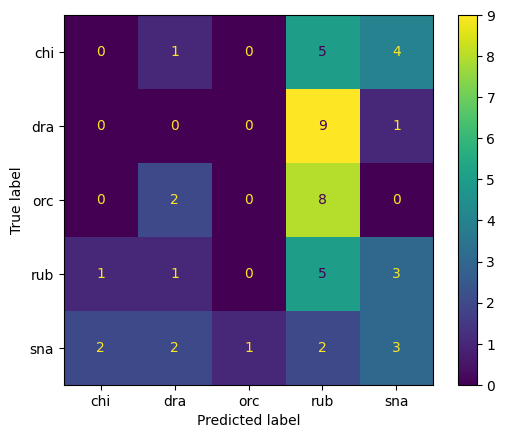

In [22]:
cm_plot_labels = ['chi', 'dra', 'orc', 'rub', 'sna']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()